In [1]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import spacy
from datetime import datetime as dt
import pytz
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

2022-10-17 16:12:51.167606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-17 16:12:51.167636: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
merged_Tweets_df = pd.read_csv('/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/merged_data.csv')

In [3]:
estimated_df = pd.read_csv('/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/estimated_test.csv')

In [4]:
AuthorID_list = merged_Tweets_df['AuthorID'].unique()

In [5]:
time_list =  merged_Tweets_df['CreateTime'].unique()

In [6]:
y_list = []
m_list = []
d_list = []
ymd_list = []
for time in time_list:
    y_list.append(int(time[0:4]))
    m_list.append(int(time[5:7]))
    d_list.append(int(time[8:10]))
    ymd_list.append(time[0:10])


ユーザーごと

In [7]:
user_sequence = merged_Tweets_df[merged_Tweets_df['AuthorID']==AuthorID_list[10]]
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
for index, r in user_sequence.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(m)
m

推論分析

In [8]:
estimated_True = estimated_df[estimated_df["code"]==estimated_df["geo_code"]]
estimated_False = estimated_df[estimated_df["code"]!=estimated_df["geo_code"]]
estimated_True = estimated_True.reset_index(drop=True)
estimated_False = estimated_False.reset_index(drop=True)

In [9]:
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
marker_cluster = MarkerCluster().add_to(m)
for index, r in estimated_True.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(marker_cluster)
m

In [10]:
m = folium.Map(location=[35.6, 139.7], zoom_start=7.0)
marker_cluster = MarkerCluster().add_to(m)
for index, r in estimated_False.iterrows():
    folium.Marker([r.UserPlase_latitude,r.UserPlase_longitude]).add_to(marker_cluster)
m

地名検出

In [11]:
# モデルのロード
nlp = spacy.load("ja_core_news_md")
# 解析対象のテキストa
input_text = "8月に東京に行く"
# モデルに解析対象のテキストを渡す
doc = nlp(input_text)
# 固有表現を抽出
for ent in doc.ents:
    print(ent.text, ent.label_, ent.start_char, ent.end_char)

8月 DATE 0 2
東京 GPE 3 5


In [12]:
estimated_True = estimated_df[estimated_df["code"]==estimated_df["geo_code"]]
estimated_False = estimated_df[estimated_df["code"]!=estimated_df["geo_code"]]
estimated_True = estimated_True.reset_index(drop=True)
estimated_False = estimated_False.reset_index(drop=True)

In [13]:
sentences_True = estimated_True.Text.values
counter_in_True=0
geo_text_list = []
for text in sentences_True:
    Flag=0
    geo_text = None
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            Flag=1
            geo_text = ent.text
    if Flag==1:
        counter_in_True+=1
    geo_text_list.append(geo_text)
counter_in_True

135

In [14]:
geo_text_list=pd.Series(geo_text_list)
estimated_True=pd.concat([estimated_True,geo_text_list],axis=1)
estimated_True=estimated_True.rename(columns={0: 'geo_text'})

In [15]:
True_no_geo_text = estimated_True[estimated_True["geo_text"].isnull()]

In [16]:
True_with_geo_text = estimated_True.dropna(subset=["geo_text"])

In [17]:
True_with_geo_text

,Unnamed: 0.1,Unnamed: 0,Keyword,CreateTime,Text,CleanedText,AuthorID,place_id,Prefecture,ConversationID,...,city_name,object,country,UserPlase_longitude,UserPlase_latitude,UserPlase_sub_longitude,UserPlase_sub_latitude,code,geo_code,geo_text
1,4,1187612476906455040,雨,2019-10-25T06:10:53.000Z,東京都千代田区、とんでもない勢いの雨降ってます☔️ まさにバケツをひっくり返したような雨,東京都千代田区、とんでもない勢いの雨降ってます☔️ まさにバケツをひっくり返したような雨,1.859650e+08,28b9063fdce43645,Tokyo,1.187612e+18,...,東京 千代田区,city,日本,139.729893,35.668551,139.782836,35.705218,5339,5339,東京都千代田区
3,9,1182950292666535936,台風,2019-10-12T09:25:02.000Z,@worldmetalmaker 揺れた、台風に地震は勘弁だネ,揺れた、台風に地震は勘弁だネ,1.049479e+18,1b0cfebe3424e14f,Tokyo,1.182950e+18,...,東京 世田谷区,city,日本,139.582428,35.590036,139.686603,35.682992,5339,5339,台風
6,17,1147818590831292417,雨,2019-07-07T10:44:12.000Z,今日雨女美桜ちゃんに負けました🙄。#真っ白なキャンバス #鈴木えま #三浦菜々子 #橋本...,今日雨女美桜ちゃんに負けました🙄。 (@ Starbucks Coffee -...,1.748317e+08,451617631d24d98c,Tokyo,1.147819e+18,...,東京 目黒区,city,日本,139.661641,35.600599,139.717749,35.664149,5339,5339,東京都 w/ @ichigojuice42
7,26,1179661392732917760,雨,2019-10-03T07:36:07.000Z,"雨がむっちゃ降ってきて出られへん^^; (@ 西友 川西店 in 川西市, 兵庫県) htt...","雨がむっちゃ降ってきて出られへん^^; (@ 西友 川西店 in 川西市, 兵庫県)",1.146460e+07,8203e9dd8c51716d,HyÅgo,1.179661e+18,...,兵庫 川西市,city,日本,135.360816,34.800688,135.469029,34.938589,5235,5235,兵庫県
8,28,1162178119756738560,台風,2019-08-16T01:43:50.000Z,台風も通過して、風がだいぶおさまってきた。\n\nそれでもブローで20m/s位は吹きます。\...,台風も通過して、風がだいぶおさまってきた。 それでもブローで20m/s位は吹きます。 午...,6.194085e+07,6d3998663bfdad9b,Kanagawa,1.162178e+18,...,神奈 川崎市 川崎区,city,日本,139.692850,35.468628,139.795387,35.541793,5339,5339,台風
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,972,1180673402383679488,雨,2019-10-06T02:37:29.000Z,#新宿御苑 \n#十月桜 と #子福桜 \n十月桜は千駄ヶ谷門方面にもあるようだが、雨のため...,と 十月桜は千駄ヶ谷門方面にもあるようだが、雨のためパス。 十月桜は今までにない咲き誇り方。,2.994111e+09,7ee61f505fdfdf5c,Tokyo,1.180673e+18,...,東京 新宿区,city,日本,139.673228,35.673404,139.745133,35.729910,5339,5339,東京都
354,982,1187687906850168833,強風,2019-10-25T11:10:37.000Z,【20:00時点 16.5℃ 89％】\n20.9~15.5℃\n(北部)★注意報:雷(南部...,【20:00時点 16.5°C 89%】 20.9~15.5°C (北部)★注意報:雷(南部...,4.818246e+08,22c3d93feadaf1c2,Shizuoka,1.187688e+18,...,静岡 浜松市 中区,city,日本,137.685262,34.679768,137.767103,34.780028,5237,5237,静岡県浜松市
356,987,1155373182641217536,雨,2019-07-28T07:03:27.000Z,"I'm at 雨引山 楽法寺 (雨引観音) in 桜川市, 茨城県 https://t.co...","I'm at 雨引山 楽法寺 (雨引観音) in 桜川市, 茨城県",7.952211e+17,da4e89b212816119,Ibaraki,1.155373e+18,...,茨城 桜川市,city,日本,140.034546,36.225531,140.189813,36.414882,5440,5440,茨城県
358,991,1183135756677599232,台風,2019-10-12T21:42:00.000Z,今朝も気象庁は河川の増水や氾濫に厳重な警戒をと。戦後最大の大型台風１９号、日が空けてくると、...,今朝も気象庁は河川の増水や氾濫に厳重な警戒をと。戦後最大の大型台風19号、日が空けてくると、...,2.742197e+08,4ad3383e25ac98d9,Tokyo,1.183136e+18,...,東京 品川区,city,日本,139.695191,35.584544,139.774255,35.641576,5339,5339,栃木県


In [18]:
True_no_geo_text

,Unnamed: 0.1,Unnamed: 0,Keyword,CreateTime,Text,CleanedText,AuthorID,place_id,Prefecture,ConversationID,...,city_name,object,country,UserPlase_longitude,UserPlase_latitude,UserPlase_sub_longitude,UserPlase_sub_latitude,code,geo_code,geo_text
0,0,1173036096466210816,台風,2019-09-15T00:49:34.000Z,【トークノーカット】草彅剛、藤竜也と「ウルトラマンタロウ」を合唱も。全国88館中継舞台挨拶『...,【トークノーカット】草彅剛、藤竜也と「ウルトラマンタロウ」を合唱も。全国88館中継舞台挨拶『...,3.547341e+08,dcc2630623880f96,Tokyo,1.173036e+18,...,東京 練馬区,city,日本,139.562887,35.711731,139.681129,35.779999,5339,5339,None
2,8,1175195374669172742,雨,2019-09-20T23:49:46.000Z,今朝も、南海電鉄：和泉大宮駅にてご挨拶！（AM6:30～8:10）怪しく分厚い雲が広がる中で...,今朝も、南海電鉄:和泉大宮駅にてご挨拶!(AM6:30~8:10)怪しく分厚い雲が広がる中で...,9.922767e+07,5aa7fafafb263f5a,Osaka,1.175195e+18,...,大阪 岸和田市,city,日本,135.345536,34.347218,135.463842,34.499614,5135,5135,None
4,13,1170304402436943872,台風,2019-09-07T11:54:47.000Z,@dminikuir 一方その頃台風15号さんは…,一方その頃台風15号さんは,1.627953e+08,735b6f2b933efaf6,Tokyo,1.170268e+18,...,東京 中央区,city,日本,139.758528,35.644646,139.793196,35.696630,5339,5339,None
5,15,1183677282524622848,台風,2019-10-14T09:33:50.000Z,@maymell11 ですよね‼️\nいつかは…分かっていても、心が拒絶します😩\n\nまし...,ですよね!!️ いつかは...分かっていても、心が拒絶します😩 まして迷子なんて。 台風...,9.046913e+17,faab662cb34cf04f,Tokyo,1.183551e+18,...,東京 杉並区,city,日本,139.585064,35.665879,139.667527,35.730446,5339,5339,None
10,32,1164017592194850816,雨,2019-08-21T03:33:15.000Z,@ssyna_ss 今日も夜には雨の予報でしたから、気をつけましょう‼️☔️👀,今日も夜には雨の予報でしたから、気をつけましょう!!️☔️👀,1.106283e+08,594fa6c6bc5b5ba9,Tokyo,1.163604e+18,...,東京 港区,city,日本,139.708754,35.622973,139.782004,35.682605,5339,5339,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,978,1146416850198130689,雨,2019-07-03T13:54:11.000Z,@pou1999 雨でやじらーがバクスタの屋根下にいたんで余計に響いたんだよ、たぶん,雨でやじらーがバクスタの屋根下にいたんで余計に響いたんだよ、たぶん,9.622698e+07,124cf982b30781ca,Saitama,1.146416e+18,...,埼玉 上尾市,city,日本,139.534032,35.925809,139.650183,36.009830,5339,5339,None
355,985,1172297854083158016,台風,2019-09-12T23:56:03.000Z,@ichiimasahide @taifu_kazoku おはよううんうん❤️🐩🐕🐶❤️\n...,おはよううんうん❤️🐩🐕🐶❤️ 剛💛🐯🤵🤴💋 金沢舞台挨拶お疲れ様でした。🤗🙏 9月...,3.310602e+09,451617631d24d98c,Tokyo,1.172031e+18,...,東京 目黒区,city,日本,139.661641,35.600599,139.717749,35.664149,5339,5339,None
357,990,1179905167996538881,雨,2019-10-03T23:44:48.000Z,@yuumari65 おはようございます🍀台風の影響なのか、朝から強い雨と風に襲われています...,おはようございます🍀台風の影響なのか、朝から強い雨と風に襲われています😢きょうは、2ヶ月に1...,2.929715e+09,49524fd7b35fd754,Tokyo,1.179864e+18,...,東京 府中市,city,日本,139.429240,35.646624,139.526371,35.699865,5339,5339,None
359,993,1188971653910253569,雨,2019-10-29T00:11:46.000Z,おはようございます☔️\n\n29日(火)\n\n昼の部 11:30〜14:30\n夜の部...,おはようございます☔️ 29日(火) 昼の部 11:30〜14:30 夜の部 18:...,1.073035e+18,db215c78c59027e4,Chiba,1.188972e+18,...,千葉 市川市,city,日本,139.885492,35.655568,139.976610,35.775796,5339,5339,None


In [19]:
True_no_geo_text["geo_code"].value_counts()

5339    209
5235      4
5237      2
5135      1
5439      1
4730      1
5136      1
4930      1
5236      1
5030      1
5338      1
5239      1
5538      1
5334      1
5539      1
Name: geo_code, dtype: int64

In [20]:
True_with_geo_text["geo_code"].value_counts()

5339    72
5235    11
5030     7
5236     6
5237     5
4930     5
5238     5
5132     3
5640     3
5340     2
5338     2
5135     2
5440     2
4931     1
5438     1
5638     1
5740     1
4929     1
5134     1
5639     1
5741     1
5940     1
5239     1
Name: geo_code, dtype: int64

In [21]:
sentences_False = estimated_False.Text.values
counter_in_False=0
geo_text_list = []
for text in sentences_False:
    Flag=0
    geo_text = None
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            Flag=1
            geo_text = ent.text
    if Flag==1:
        counter_in_False+=1
    geo_text_list.append(geo_text)
counter_in_False

134

In [22]:
geo_text_list=pd.Series(geo_text_list)
estimated_False=pd.concat([estimated_False,geo_text_list],axis=1)
estimated_False=estimated_False.rename(columns={0: 'geo_text'})

In [23]:
False_with_geo_text = estimated_False.dropna(subset=["geo_text"])

In [24]:
False_with_geo_text 

,Unnamed: 0.1,Unnamed: 0,Keyword,CreateTime,Text,CleanedText,AuthorID,place_id,Prefecture,ConversationID,...,city_name,object,country,UserPlase_longitude,UserPlase_latitude,UserPlase_sub_longitude,UserPlase_sub_latitude,code,geo_code,geo_text
6,10,1169687167444164608,台風,2019-09-05T19:02:07.000Z,欧米のスパコン台風予測、米国GFS更新 (^-^)/ https://t.co/iJ9nFz...,欧米のスパコン台風予測、米国GFS更新 (^-^)/,1.033665e+08,77890cc3b730bd37,Kagoshima,1.168410e+18,...,鹿児 鹿児島市,city,日本,130.386605,31.293058,130.724893,31.752560,4630,5339,米国
14,21,1182180297330135041,台風,2019-10-10T06:25:21.000Z,@KazumaShowma こんにちは！群馬もお天気なんですね☀️\n台風来る前に洗濯は大事...,こんにちは!群馬もお天気なんですね☀️ 台風来る前に洗濯は大事ですね!( ́∇`),2.726995e+08,1b3ca87d8d923c40,Niigata,1.182113e+18,...,新潟 村上市,city,日本,139.407614,38.078229,139.900074,38.553764,5739,5439,群馬
17,24,1164978604427501568,雨,2019-08-23T19:11:58.000Z,ポツポツと雨。今日はこれから晴れるのかな？さて本日の出走馬は札幌3頭に新潟1頭。未勝利戦も来...,ポツポツと雨。今日はこれから晴れるのかな?さて本日の出走馬は札幌3頭に新潟1頭。未勝利戦も来...,3.893392e+08,080ce2c3fda14964,Ibaraki,1.164979e+18,...,茨城 美浦村,city,日本,140.268424,35.973364,140.411399,36.048952,5340,5339,新潟
20,29,1180897779385683968,雨,2019-10-06T17:29:05.000Z,ただいま🚘\n東京めちゃ雨降ってて大変でした☔️,ただいま🚘 東京めちゃ雨降ってて大変でした☔️,8.235015e+17,658025f3b87efc97,Hiroshima,1.180898e+18,...,広島 福山市,city,日本,133.210533,34.332373,133.456436,34.712255,5133,5339,東京
29,43,1179874082377977856,台風,2019-10-03T21:41:16.000Z,@azuminofm #azuminofm \nおはようございます！\n気温24℃湿度74...,おはようございます! 気温24°C湿度74%風速7メートルと少し強めの風が吹いている千葉県九...,9.900636e+08,d88b0daf299cb0ab,Chiba,1.179874e+18,...,千葉 長生村,city,日本,140.312074,35.380735,140.398061,35.434718,5340,5339,千葉県九十九里浜地方
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,967,1178055085235949569,台風,2019-09-28T21:13:14.000Z,「電線ずたずた大変です」台風１５号でＳＯＳ 千葉と兵庫、鉄道マンの絆（神戸新聞NEXT） h...,「電線ずたずた大変です」台風15号でSOS 千葉と兵庫、鉄道マンの絆(神戸新聞NEXT) ...,2.185528e+09,920d3a170bebcb1a,Kanagawa,1.178055e+18,...,神奈 相模原市 中央区,city,日本,139.328016,35.515530,139.434503,35.592225,5339,5235,千葉
618,968,1175599841369452548,台風,2019-09-22T02:36:58.000Z,明日、メディア館のヴァイスショップ大会に行こうと思ったけども、台風が新潟に一番近くなるから、...,明日、メディア館のヴァイスショップ大会に行こうと思ったけども、台風が新潟に一番近くなるから、...,1.054657e+09,1f63ea6d6ab91817,Niigata,1.175600e+18,...,新潟 上越市,city,日本,138.067843,36.940617,138.568509,37.306664,5538,5639,新潟
623,976,1178633299180191744,台風,2019-09-30T11:30:51.000Z,台風18号、うさぎ亭の宮が遷都した鹿児島と、東京をうまいこと迂回するルートになってきた(^-...,台風18号、うさぎ亭の宮が遷都した鹿児島と、東京をうまいこと迂回するルートになってきた(^-^)/,1.033665e+08,77890cc3b730bd37,Kagoshima,1.176866e+18,...,鹿児 鹿児島市,city,日本,130.386605,31.293058,130.724893,31.752560,4630,4730,東京
627,981,1170685413108772864,台風,2019-09-08T13:08:47.000Z,台風…お願いだから早く過ぎ去って😣💧\n頭ガチ割れそうに、ガンガン痛い😖\n薬も効かない😱 ...,台風...お願いだから早く過ぎ去って😣💧 頭ガチ割れそうに、ガンガン痛い😖 薬も効かない😱 ...,2.873472e+09,ff72a1c885de5a00,Kanagawa,1.170685e+18,...,神奈 大磯町,city,日本,139.250704,35.297380,139.334091,35.334477,5239,5339,ガンガン


In [24]:
False_no_geo_text = estimated_False[estimated_False["geo_text"].isnull()]

In [25]:
False_no_geo_text

,Unnamed: 0.1,Unnamed: 0,Keyword,CreateTime,Text,CleanedText,AuthorID,place_id,Prefecture,ConversationID,...,city_name,object,country,UserPlase_longitude,UserPlase_latitude,UserPlase_sub_longitude,UserPlase_sub_latitude,code,geo_code,geo_text
0,1,1182195555746713600,台風,2019-10-10T07:25:59.000Z,これ見てでも\n台風の日外出したいという方は\n死にたければどーぞ https://t.co...,これ見てでも 台風の日外出したいという方は 死にたければどーぞ,2.921909e+09,a4146ed4af710640,Okinawa,1.182196e+18,...,沖縄 浦添市,city,日本,127.668702,26.233069,127.753011,26.274911,3927,5339,None
1,2,1182045306143174656,台風,2019-10-09T21:28:56.000Z,@okanarumi おはようございます\n\n台風注意してください‼️ね,おはようございます 台風注意してください!!️ね,1.074145e+18,0b89db31d164a17d,Hokkaido,1.181888e+18,...,日本 北海道,admin,日本,139.334717,41.351745,145.817459,45.522785,6239,5339,None
2,3,1177387218488315904,台風,2019-09-27T00:59:22.000Z,9/27 8時更新、米国GFSスパコン予測による来週の台風予測。風速表示。 https://...,9/27 8時更新、米国GFSスパコン予測による来週の台風予測。風速表示。,1.033665e+08,77890cc3b730bd37,Kagoshima,1.176866e+18,...,鹿児 鹿児島市,city,日本,130.386605,31.293058,130.724893,31.752560,4630,5339,None
3,5,1183013576979566594,台風,2019-10-12T13:36:30.000Z,今日１日報道で何回「命」という言葉を聞いたことか。台風警報は解除になったが、大雨警報は出たま...,今日1日報道で何回「命」という言葉を聞いたことか。台風警報は解除になったが、大雨警報は出たま...,8.354556e+17,7d93637162dd8434,Shizuoka,1.183014e+18,...,静岡 富士市,city,日本,138.557505,35.115342,138.811869,35.359319,5238,5339,None
4,6,1175220847717470208,雨,2019-09-21T01:30:59.000Z,@IYOKAN_R_yokkin 雨持って良かったです🤣,雨持って良かったです🤣,1.367278e+09,0809644c2c399a48,Ehime,1.175215e+18,...,愛媛 松山市,city,日本,132.491125,33.687285,132.926666,34.073779,5032,5339,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,992,1181226063126388736,台風,2019-10-07T15:13:34.000Z,今回の台風19号、予想進路からふと伊勢湾台風が頭をよぎりました。\nなんとか進路予想が東向き...,今回の台風19号、予想進路からふと伊勢湾台風が頭をよぎりました。 なんとか進路予想が東向きに...,3.508484e+08,6edfb23dd9a61592,HyÅgo,1.181226e+18,...,兵庫 三田市,city,日本,135.092530,34.872403,135.310620,35.037140,5235,5339,None
634,996,1154984371952078849,台風,2019-07-27T05:18:27.000Z,台風どこにいるの！笑 https://t.co/w9eIlrV0sY,台風どこにいるの!笑,8.898423e+17,6856a6b23273646a,Kanagawa,1.154984e+18,...,神奈 小田原市,city,日本,139.059859,35.177945,139.238383,35.330090,5239,5339,None
635,997,1146307448916963329,雨,2019-07-03T06:39:27.000Z,夏の暑さと、梅雨の時期の雨、死ぬのと一緒くらいムリ。,夏の暑さと、梅雨の時期の雨、死ぬのと一緒くらいムリ。,2.104864e+08,e2c6cab4508c3700,Hiroshima,1.146307e+18,...,広島 広島市 西区,city,日本,132.373352,34.355481,132.465752,34.432814,5132,5339,None
636,998,1183190706053099520,台風,2019-10-13T01:20:21.000Z,訂正10時時点で９４t\n…下の観望台には台風(暴風雨)が残っております,訂正10時時点で94t ...下の観望台には台風(暴風雨)が残っております,1.476494e+09,33cd06ef43d91645,Tochigi,1.183187e+18,...,栃木 日光市,city,日本,139.326381,36.600962,139.853647,37.091820,5439,5339,None


In [26]:
False_with_geo_text['geo_code'].value_counts()

5339    75
5235     6
3927     4
5440     4
5236     4
4730     4
5135     4
5639     3
5239     3
6441     2
5237     2
4930     2
5439     2
5134     2
5238     2
5336     2
5340     2
5334     1
5740     1
5941     1
5131     1
4731     1
4630     1
5338     1
6440     1
5234     1
5940     1
5436     1
Name: geo_code, dtype: int64

In [27]:
False_no_geo_text['geo_code'].value_counts()

5339    436
5235     19
5239      7
5030      6
5436      3
4930      3
5236      3
5338      2
3927      2
5135      2
5238      2
6444      2
5237      2
5639      2
5440      1
5336      1
5438      1
5340      1
6240      1
6542      1
5538      1
5841      1
5640      1
5539      1
5136      1
5740      1
5234      1
Name: geo_code, dtype: int64

時間分析

１dayごと

In [28]:
time_line_df = pd.read_csv("/home/is/shuntaro-o/dev/disaster_analysis_Twitter/data/Hurricane/split_time.csv")

In [29]:
compare_times = time_line_df.ymd.unique()

In [30]:
compare_times.sort()

In [31]:
tweet_nums_per_day = []
for i in compare_times:
    tweet_nums_per_day.append(len(time_line_df[time_line_df['ymd']==i]))

In [32]:
hour_for_xlabel = []
for i in compare_times:
    hour_for_xlabel.append(str(i)[-2:])

In [33]:
xlabel = []
for i in compare_times:
    xlabel.append('{}/{}'.format(str(i)[4:6],str(i)[6:8]))


In [34]:
len(xlabel)

123

Text(0, 0.5, 'sum_tweets')

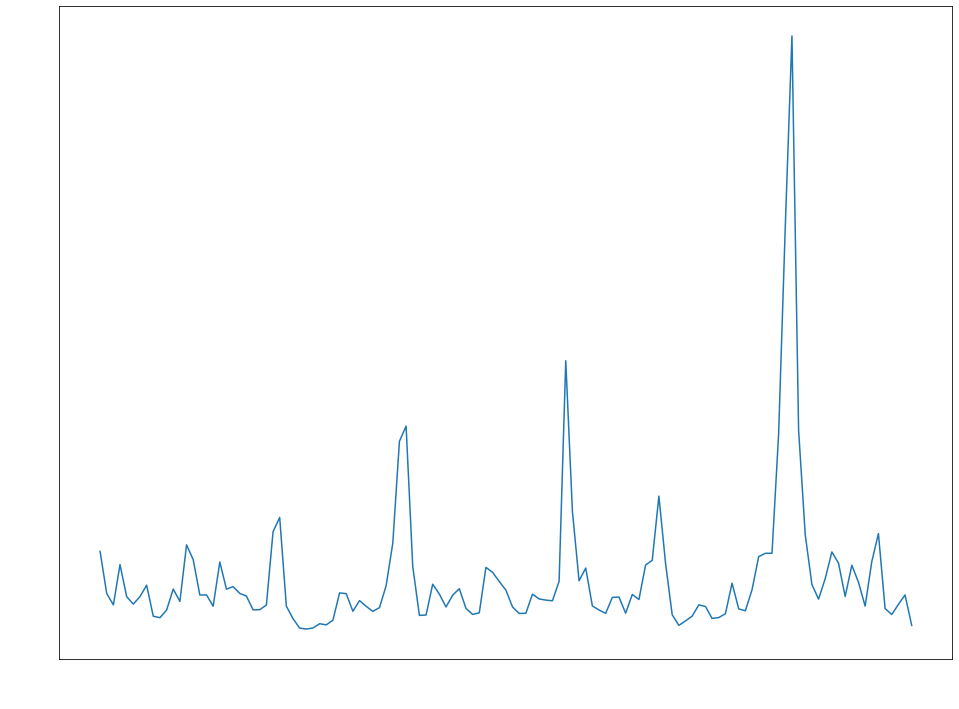

In [35]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 123, 10))
plt.plot(xlabel,tweet_nums_per_day)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

1hourごと
hagibis

In [36]:
compare_times_hour = time_line_df.ymdh.unique()
compare_times_hour.sort()
compare_times_hour = compare_times_hour[2328:2592]

In [37]:
xlabel_hour = []
for i in compare_times_hour:
    xlabel_hour.append('{}/{}/{}'.format(str(i)[4:6],str(i)[6:8],str(i)[8:10]))

In [38]:
tweet_nums_per_hour = []
for i in compare_times_hour:
    tweet_nums_per_hour.append(len(time_line_df[time_line_df['ymdh']==i]))

Text(0, 0.5, 'sum_tweets')

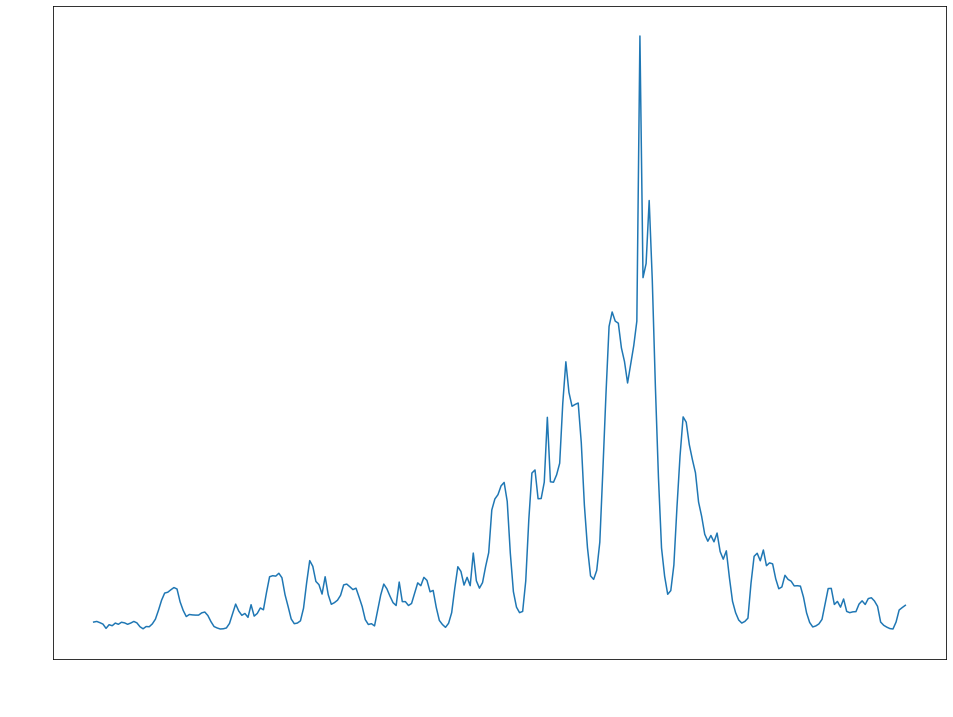

In [39]:
from turtle import color


plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 264, 24))
plt.plot(xlabel_hour,tweet_nums_per_hour)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

#地域ごと

In [40]:
compare_times_hour = time_line_df.ymdh.unique()
compare_times_hour.sort()
compare_times_hour = compare_times_hour[2328:2592]

In [41]:
xlabel_hour = []
for i in compare_times_hour:
    xlabel_hour.append('{}/{}/{}'.format(str(i)[4:6],str(i)[6:8],str(i)[8:10]))

In [42]:
tweet_nums_per_hour_lon_to_130 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_130.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']<=130)]))

In [43]:
tweet_nums_per_hour_lon_to_133 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_133.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>130)& (time_line_df['UserPlase_longitude']<=133)]))

In [44]:
tweet_nums_per_hour_lon_to_136 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_136.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>133)& (time_line_df['UserPlase_longitude']<=136)]))

In [45]:
tweet_nums_per_hour_lon_to_139 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_139.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>136)& (time_line_df['UserPlase_longitude']<=139)]))

In [46]:
tweet_nums_per_hour_lon_to_142 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_142.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>139)& (time_line_df['UserPlase_longitude']<=142)]))

In [47]:
tweet_nums_per_hour_lon_to_145 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_to_145.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>142)& (time_line_df['UserPlase_longitude']<=145)]))

In [48]:
tweet_nums_per_hour_lon_over_145 = []
for i in compare_times_hour:
    tweet_nums_per_hour_lon_over_145.append(len(time_line_df[(time_line_df['ymdh']==i) & (time_line_df['UserPlase_longitude']>145)]))

Text(0, 0.5, 'sum_tweets')

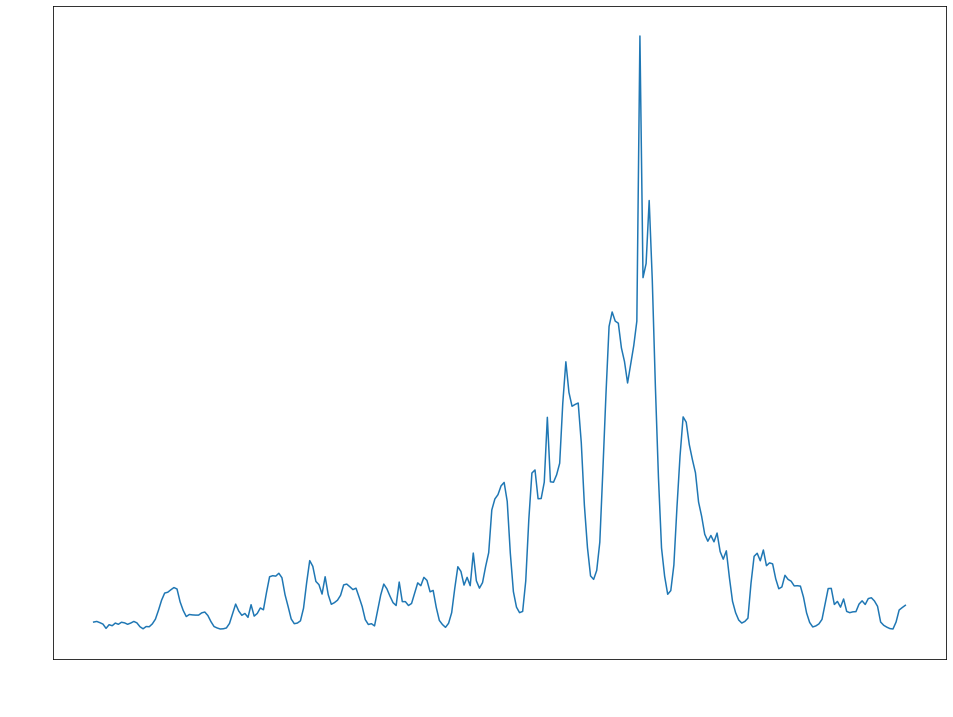

In [49]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.xticks(rotation=30)
plt.tick_params(direction = "inout", length = 5, colors = "white")
plt.xticks(np.arange(0, 264, 24))
plt.plot(xlabel_hour,tweet_nums_per_hour)
plt.xlabel("time",color="white")
plt.ylabel("sum_tweets",color="white")

In [50]:
print(len(xlabel_hour))
print(len(tweet_nums_per_hour))
print(len(tweet_nums_per_hour_lon_to_130))
print(len(tweet_nums_per_hour_lon_to_133))
print(len(tweet_nums_per_hour_lon_to_136))
print(len(tweet_nums_per_hour_lon_to_139))
print(len(tweet_nums_per_hour_lon_to_142))
print(len(tweet_nums_per_hour_lon_over_145))

264
264
264
264
264
264
264
264


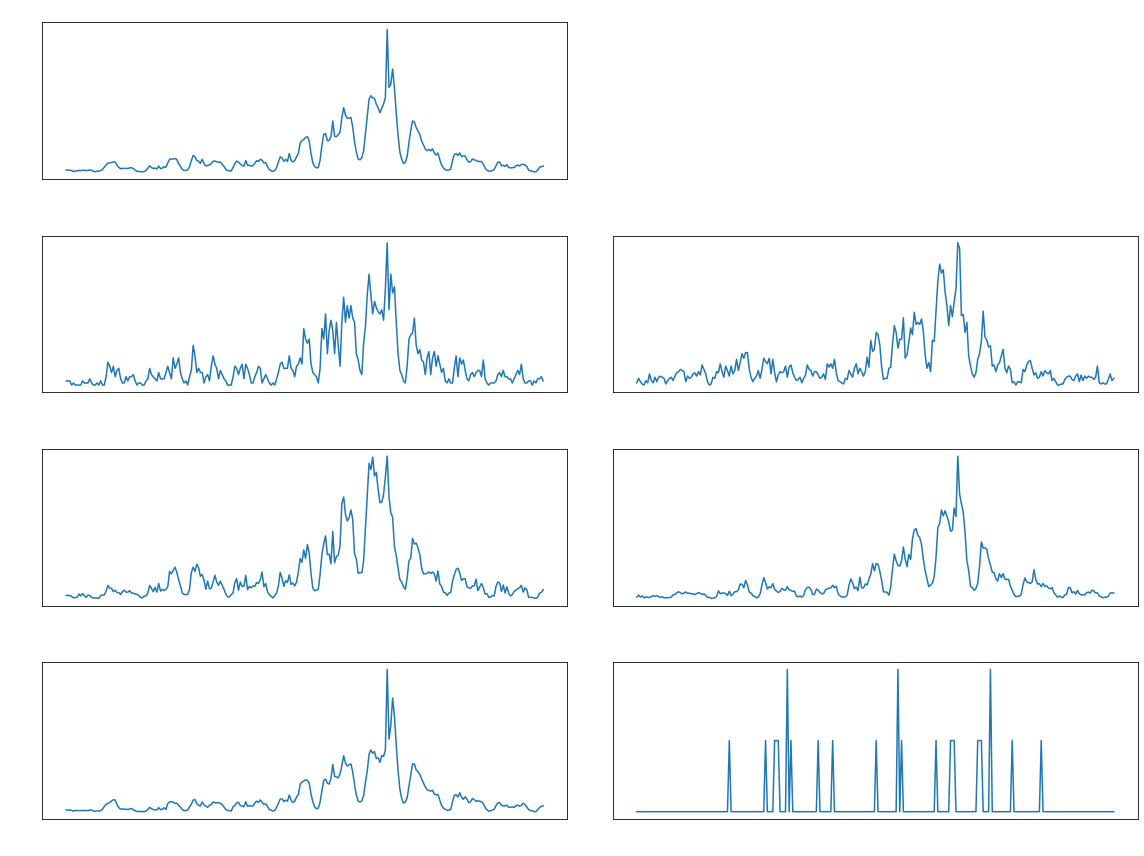

In [55]:
fig = plt.figure()
#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 3)
ax3 = fig.add_subplot(4, 2, 4)
ax4 = fig.add_subplot(4, 2, 5)
ax5 = fig.add_subplot(4, 2, 6)
ax6 = fig.add_subplot(4, 2, 7)
ax7 = fig.add_subplot(4, 2, 8)

t = xlabel_hour
y1 = tweet_nums_per_hour
y2 = tweet_nums_per_hour_lon_to_130
y3 = tweet_nums_per_hour_lon_to_133
y4 = tweet_nums_per_hour_lon_to_136
y5 = tweet_nums_per_hour_lon_to_139
y6 = tweet_nums_per_hour_lon_to_142
y7 = tweet_nums_per_hour_lon_over_145

y1 = scipy.stats.zscore(y1)
y2 = scipy.stats.zscore(y2)
y3 = scipy.stats.zscore(y3)
y4 = scipy.stats.zscore(y4)
y5 = scipy.stats.zscore(y5)
y6 = scipy.stats.zscore(y6)
y7 = scipy.stats.zscore(y7)

ax1.plot(t, y1)
ax2.plot(t, y2)
ax3.plot(t, y3)
ax4.plot(t, y4)
ax5.plot(t, y5)
ax6.plot(t, y6)
ax7.plot(t, y7)


ax1.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax1.set_title("lon_under_130",color="white")
ax1.set_xticks(np.arange(0, 264, 48))
ax1.set_xlabel("time",color="white")
#ax1.set_xticks(rotation=45)
ax1.set_ylabel("sum_tweets",color="white")

ax2.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax2.set_title("130to133",color="white")
ax2.set_xticks(np.arange(0, 264, 48))
ax2.set_xlabel("time",color="white")
#ax2.set_xticks(rotation=45)
ax2.set_ylabel("sum_tweets",color="white")

ax3.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax3.set_title("133to136",color="white")
ax3.set_xticks(np.arange(0, 264, 48))
ax3.set_xlabel("time",color="white")
#ax3.set_xticks(rotation=45)
ax3.set_ylabel("sum_tweets",color="white")

ax4.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax4.set_title("136to139",color="white")
ax4.set_xticks(np.arange(0, 264, 48))
ax4.set_xlabel("time",color="white")
#ax4.set_xticks(rotation=45)
ax4.set_ylabel("sum_tweets",color="white")

ax5.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax5.set_title("139to142",color="white")
ax5.set_xticks(np.arange(0, 264, 48))
ax5.set_xlabel("time",color="white")
#ax5.set_xticks(rotation=45)
ax5.set_ylabel("sum_tweets",color="white")

ax6.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax6.set_title("142to145",color="white")
ax6.set_xticks(np.arange(0, 264, 48))
ax6.set_xlabel("time",color="white")
#ax6.set_xticks(rotation=45)
ax6.set_ylabel("sum_tweets",color="white")

ax7.tick_params(direction = "inout", length = 5, colors = "white")
#repeate_code
ax7.set_title("over_145",color="white")
ax7.set_xticks(np.arange(0, 264, 48))
ax7.set_xlabel("time",color="white")
#ax7.set_xticks(rotation=45)
ax7.set_ylabel("sum_tweets",color="white")

fig.tight_layout()              #レイアウトの設定
plt.show()